In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# dataset 불러오기

train_data = np.loadtxt('/content/training.dat', unpack = True)
test_data = np.loadtxt('/content/testing.dat', unpack = True)

In [ ]:
# train, test data 75개
# 25개씩 나눠져서 총 3개의 클래스
# 3개의 클래스 돌면서 라벨링 
# one-hot encoding
# >> 라벨값이 0 = [1, 0, 0] / 1 = [0, 1, 0] / 2 = [0, 0, 1]

train_label = []
test_label = []

for i in range(3):
    for j in range(25):
        label = np.zeros(3)
        label[i] = 1
        train_label.append(label)
        test_label.append(label)
    
train_label = np.array(train_label).T
test_label = np.array(test_label).T

In [ ]:
# train의 shape / test의 shape

print(train_data.shape)
print(test_data.shape)

(4, 75)
(4, 75)


In [ ]:
# 사용할 활성화 함수 : ReLu
# 마지막 layer에서 사용할 softmax 함수

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis = 0)

In [ ]:
# 모델 정의
# 파라미터 : X_train, y_train, learning_rate, epoch, activation function

def model(X_train, y_train, learning_rate = 0.1, num_iterations = 20, activation = relu):

    # 모델의 구조
    # input : X.shape[0] = 4 / hidden layer는 100, 100 노드 
    # output : softmax를 통해 3개의 클래스 중 분류하므로 3
    layer_dims = [X_train.shape[0], 100, 100, 3]  

    # grads -> 미분값 담기
    grads = {}

    train_costs = []
    test_costs = []

    # parameters -> 가중치값 담기
    # 추후 두개의 딕셔너리를 통해 가중치에서 미분값을 연산해 가중치 조정
    parameters = {}

    # 가중치 초기화
    # Glorot Initialization
    for i in range(1, len(layer_dims)):
        m = np.sqrt(6 / (layer_dims[i] + layer_dims[i - 1]))
        parameters['W' + str(i)] = np.random.uniform(-m, m, size = (layer_dims[i], layer_dims[i - 1]))

    # num_iteration
    for i in range(0, num_iterations):  

        # 순전파
        # 가중치 W1, W2, W3
        W1 = parameters["W1"] #input -- hidden1
        W2 = parameters["W2"] # hidden1 -- hidden2
        W3 = parameters["W3"] # hidden2 -- output

        # W1, input을 연산 (hidden1이 활성화 함수를 거치기 전)
        Z1 = np.dot(W1, X_train)
        # Z1이 활성화 함수를 거친 후 (hidden1의 출력값) 
        A1 = activation(Z1)

        # W2, A1을 연산 (hidden2가 활성화 함수를 거치기 전)
        Z2 = np.dot(W2, A1)
        # Z2가 활성화 함수를 거친 후 (hidden2의 출력값) 
        A2 = activation(Z2)

        # W3, A2을 연산 (최종 output이 활성화 함수를 거치기 전)
        Z3 = np.dot(W3, A2)

        # output에 softmax를 거쳐 총 3개의 값이 나옴
        # 3개의 값이라고 할 때, 3개를 합치면 1 >> [0.1, 0.1, 0.8] 과 같이 모든 값을 합치면 1이 나옴
        # 추후에 예측 과정에서 제일 높은 숫자를 가진 인덱스를 추출할 것 ([0.1, 0.1, 0.8] 이라면 0.8이 제일 높은 확률을 가지므로 예측 결과는 [0, 0, 1] 즉, 2가 됨)
        y_pred = softmax(Z3)

        # 비용함수
        # Cross-Entropy
        # softmax 함수를 거친 최종 output값이 자신의 라벨값과 비슷해질수록 낮아짐
        # >>  실제 라벨이 [0, 0, 1] 이라면 / [0.1, 0.1, 0.8] 이 [0.2, 0.2, 0.6] 보다 낮은 loss값을 가짐
        m = y_train.shape[1]
        logprobs = np.multiply(-np.log(y_pred), y_train) + np.multiply(-np.log(1 - y_pred), 1 - y_train)
        cost = 1./m * np.sum(logprobs)  


        # 역전파
        m = X_train.shape[1] 
        
        # dZ3 는 최종 output과 실제값의 차이
        # 각각의 dW 계산(- learning_rate * np.outer(전 계층_out, 위에서 내려온_delta))
        dZ3 = y_pred - y_train
        dW3 = 1./m * np.dot(dZ3, A2.T)

        dA2 = np.dot(W3.T, dZ3)
        dZ2 = np.multiply(dA2, np.where(np.dot(W2, A1) > 0, 1, 0))
        dW2 = 1./m * np.dot(dZ2, A1.T)
        
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.multiply(dA1, np.where(np.dot(W1, X_train) > 0, 1, 0))
        dW1 = 1./m * np.dot(dZ1, X_train.T)
        
        grads = {"dZ3": dZ3, "dW3": dW3, 
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, 
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1,}

        
        # 가중치 업데이트
        # grads : 미분값
        # parameters : 가중치값
        # W = W - lr * dW 식을 이용해서 가중치를 업데이트
        for k in range(len(parameters) // 2):
            parameters["W" + str(k + 1)] = parameters["W" + str(k + 1)] - learning_rate * grads["dW" + str(k + 1)]
        
        # 최종적으로 구해진 오차값 저장
        print("Cost after iteration {}: {}".format(i, cost))
        train_costs.append(cost)
    
    # 저장된 오차값 plot
    # x축 : epoch / y축 : 오차값
    plt.plot(train_costs, color = 'blue')
    plt.ylabel('training_cost')
    plt.xlabel('iterations')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    # 최종적으로 구해진 가중치값을 리턴해준다
    return parameters     # 오차의 계산

Cost after iteration 0: 1.820892024257944
Cost after iteration 1: 1.7219184690979343
Cost after iteration 2: 1.6651939931962532
Cost after iteration 3: 1.6200989746419359
Cost after iteration 4: 1.5776212240644485
Cost after iteration 5: 1.5460226339272327
Cost after iteration 6: 1.5227550694183534
Cost after iteration 7: 1.5034939363051107
Cost after iteration 8: 1.4861787138906062
Cost after iteration 9: 1.4706125950504942
Cost after iteration 10: 1.4564951610175214
Cost after iteration 11: 1.443122775272619
Cost after iteration 12: 1.4300514628205896
Cost after iteration 13: 1.4182699789496584
Cost after iteration 14: 1.406079262468106
Cost after iteration 15: 1.39482153177749
Cost after iteration 16: 1.382440205256037
Cost after iteration 17: 1.3697834679527179
Cost after iteration 18: 1.355062814962252
Cost after iteration 19: 1.3395388820575054
Cost after iteration 20: 1.3252799694201085
Cost after iteration 21: 1.3120211665199297
Cost after iteration 22: 1.3008337494307796
Cost 

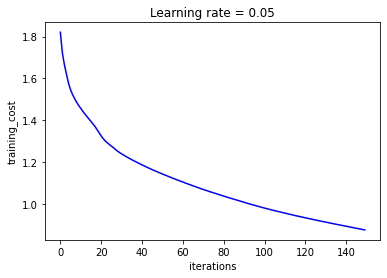

In [ ]:
parameters = model(train_data, train_label, learning_rate = 0.05, num_iterations = 150, activation = relu)

In [ ]:
# 예측 함수
# 저장된 가중치값을 가지고 있기 때문에
# test 데이터를 이 가중치값으로 순전파를 통과시켜주면 모델의 예측값이 나옴
def predict(X_train, y_train, parameters, activation = relu):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    # 위의 훈련시 사용한 순전파 모델
    Z1 = np.dot(W1, X_train)
    A1 = activation(Z1)
    Z2 = np.dot(W2, A1)
    A2 = activation(Z2)
    Z3 = np.dot(W3, A2)
    y_pred = softmax(Z3)

    # y_pred 값은 총 3개의 데이터로 이뤄져 있기 때문에
    # 그대로 사용 x ([0.1, 0.2, 0.7] 이런식으로 각 클래스에 대한 확률이 나와있음)
    # 제일 큰 확률을 가진 클래스를 찾아주는 과정 필요 -> np.argmax()
    prediction = np.argmax(y_pred, axis = 0)
    return prediction

# 이렇게 얻은 모델 가중치로 training data, test data를 각각 예측해본 결과
# 정확도
train_pred = predict(train_data, train_label, parameters)
print ("On the training set :")
print("Accuracy : "  + str(np.mean((train_pred[:] == np.argmax(train_label, axis = 0)))))

test_pred = predict(test_data, test_label, parameters)
print ("\nOn the test set :")
print("Accuracy : "  + str(np.mean((test_pred[:] == np.argmax(test_label, axis = 0)))))

On the training set :
Accuracy : 0.96

On the test set :
Accuracy : 0.96
